In [1]:
%run '/Users/itaymi/Desktop/Python/Functions.ipynb'
display(HTML('<style>.container{width:100% !important;}</style>'))

### Imports

In [2]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import shap
shap.initjs()

### Import data

In [3]:
df = pd.read_csv('Churn.csv')

# convert to numeric
format_fixer(df,['TotalCharges'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges']).fillna(0)

df.drop('customerID', axis = 1, inplace = True)

print(f'Dataframe length = {len(df):,}')

df.head(3)

Dataframe length = 7,043


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
# null values
df.isna().sum().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [6]:
for col in df.columns:
    if df[col].nunique() <= 10:
        print(df[col].value_counts(dropna = False)), print('')

gender
Male      3555
Female    3488
Name: count, dtype: int64

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

TechSupport
No                     3473
Yes                    2044
No internet service    15

### Label encoding

In [7]:
df['IsMale'] = df['gender'].map({'Male':1,'Female':0})
df.drop('gender', axis = 1, inplace = True)

for col in df.columns:
    unique_values = df[col].unique()

    if set(unique_values) == {'Yes','No'}:
        labels1 = {'Yes':1,'No':0}
        df[col] = df[col].replace(labels1)
    
    elif set(unique_values) == {'No','No internet service','Yes'} or set(unique_values) == {'No','No phone service','Yes'}:
        labels2 = {'Yes':1,'No':0,'No internet service':-1,'No phone service':-1}
        df[col] = df[col].replace(labels2)
    
    elif len(unique_values) > 2 and len(unique_values) < 7:
        df = pd.get_dummies(df, columns = [col], dtype = int, prefix_sep = ' | ', drop_first = False)
        
for col in df.columns:
    if df[col].nunique() <= 10:
        print(df[col].value_counts(dropna = False)), print('')

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

Partner
0    3641
1    3402
Name: count, dtype: int64

Dependents
0    4933
1    2110
Name: count, dtype: int64

PhoneService
1    6361
0     682
Name: count, dtype: int64

MultipleLines
 0    3390
 1    2971
-1     682
Name: count, dtype: int64

OnlineSecurity
 0    3498
 1    2019
-1    1526
Name: count, dtype: int64

OnlineBackup
 0    3088
 1    2429
-1    1526
Name: count, dtype: int64

DeviceProtection
 0    3095
 1    2422
-1    1526
Name: count, dtype: int64

TechSupport
 0    3473
 1    2044
-1    1526
Name: count, dtype: int64

StreamingTV
 0    2810
 1    2707
-1    1526
Name: count, dtype: int64

StreamingMovies
 0    2785
 1    2732
-1    1526
Name: count, dtype: int64

PaperlessBilling
1    4171
0    2872
Name: count, dtype: int64

Churn
0    5174
1    1869
Name: count, dtype: int64

IsMale
1    3555
0    3488
Name: count, dtype: int64

InternetService | DSL
0    4622
1    2421
Name: count, dtype: int64

Interne

In [8]:
value_counts_2(df, 'Churn')

Total values = 7,043


,Count,% Total
CHURN,,
0,5174,73.46
1,1869,26.54


### Numeric scaling & spliting

In [9]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

scaler = Normalizer()
scaled_data = scaler.fit_transform(df[cols_to_scale])
scaled_df = pd.DataFrame(scaled_data, index = df.index, columns = cols_to_scale)

df.drop(cols_to_scale, axis = 1, inplace = True)
df = pd.merge(df, scaled_df, left_index = True, right_index = True)

pop_col = df.pop('Churn')
df.insert(len(df.columns), 'Churn', pop_col)

X = df.drop('Churn', axis = 1)
y = df['Churn'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f'X_train #values = {len(X_train):,}')
print(f'X_test #values  = {len(X_test):,}')

X_train #values = 5,634
X_test #values  = 1,409


### Training the model

In [10]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
ratio = 1

model = xgb.XGBClassifier(
                          scale_pos_weight = ratio, 
                          objective = 'binary:logistic', 
                          n_estimators = 100,
                          learning_rate = 0.15,
                          subsample = 0.8,
                          colsample_bytree = 0.3, 
                          min_child_weight = 1,
                          gamma = 0.0,
                          reg_lambda = 5,
                          reg_alpha = 0.1,
                          max_depth = 4,
                          n_iter = 5,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 3
                         )

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

df['pred_churn'] = model.predict(X)
df['pred_probability'] = model.predict_proba(X)[:, 1]

accuracy = model.score(X_test,y_test)
print(f'Accuracy score = {round(accuracy*100,2)}%'), print('')
print(classification_report(y_test, y_pred))

Accuracy score = 80.84%

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.68      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



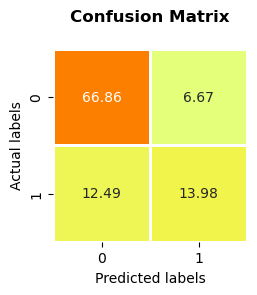

In [11]:
cm = confusion_matrix(y_test, model.predict(X_test))

plt.figure(figsize = (2.5,2.5))

cm_percent = cm / cm.sum() * 100
sns.heatmap(cm_percent, annot = True, fmt = '.2f', cmap = 'Wistia', cbar = False, linewidths = 2)
plt.xlabel('Predicted labels'), plt.ylabel('Actual labels')
plt.title('Confusion Matrix', weight = 'bold', pad = 20);

### Hyperparameter Tuning

In [12]:
params = {
          'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
          'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
          'min_child_weight': [1, 3, 5, 7],
          'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
          'subsample': [0.6, 0.7, 0.8, 0.9],
          'reg_alpha': [0, 0.1, 0.5, 1],
          'reg_lambda': [0.1, 1, 5, 10],
          'n_estimators': [100, 200, 300, 400, 500]
         }

classifier = xgb.XGBClassifier()
random_search = RandomizedSearchCV(classifier, param_distributions = params, n_iter = 5, scoring = 'accuracy', n_jobs = -1, cv = 5, verbose = 3)

random_search.fit(X_train, y_train)

print(''), print(f'Best Parameters = {random_search.best_params_}')
print(f'Best Accuracy Score = {round(random_search.best_score_*100,2)}%')

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Parameters = {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.3}
Best Accuracy Score = 79.77%


### SHAP explainer

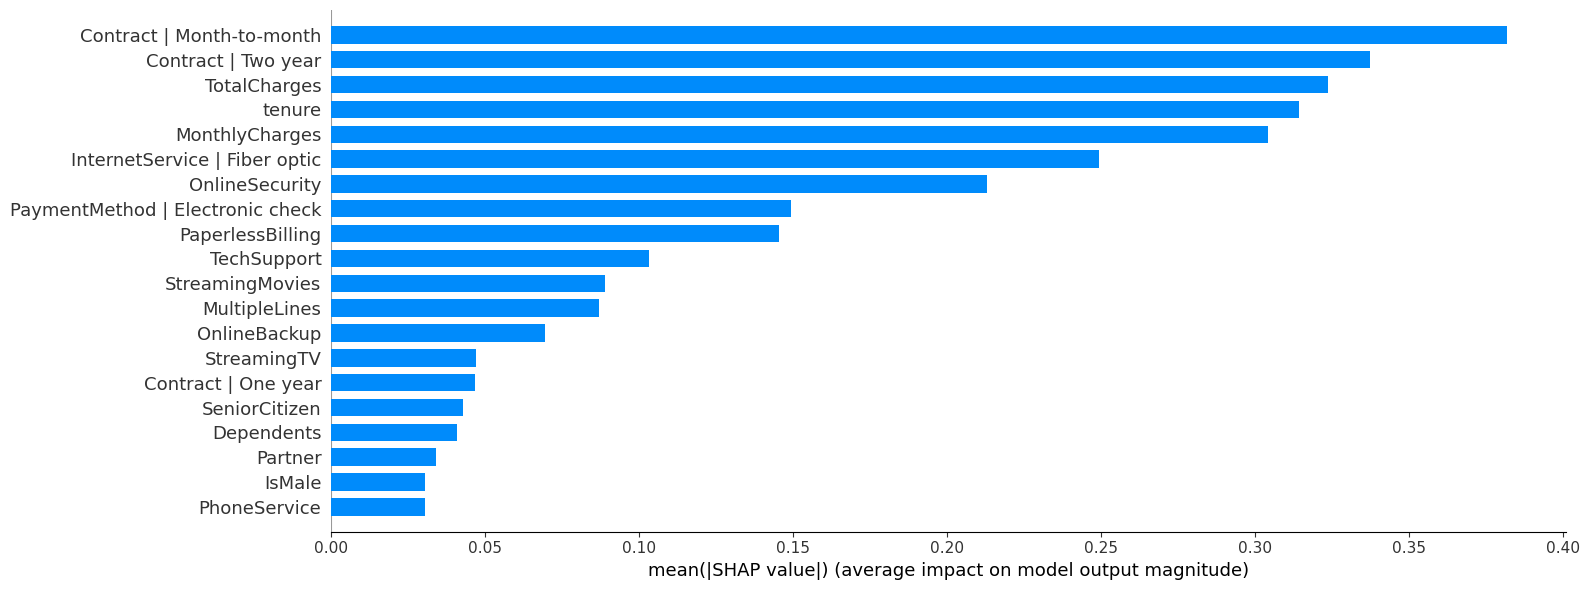

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X, plot_type = 'bar', plot_size = (16,6))

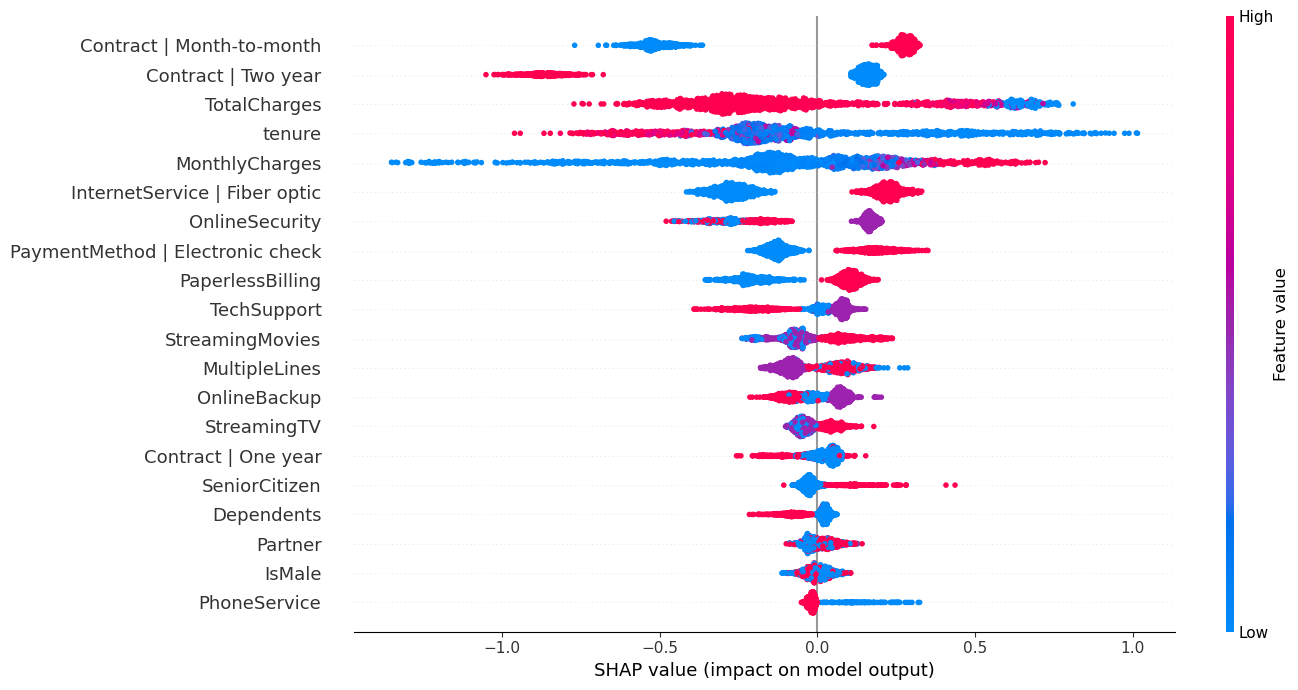

In [14]:
shap.summary_plot(shap_values, X_test, plot_size = (14,7))

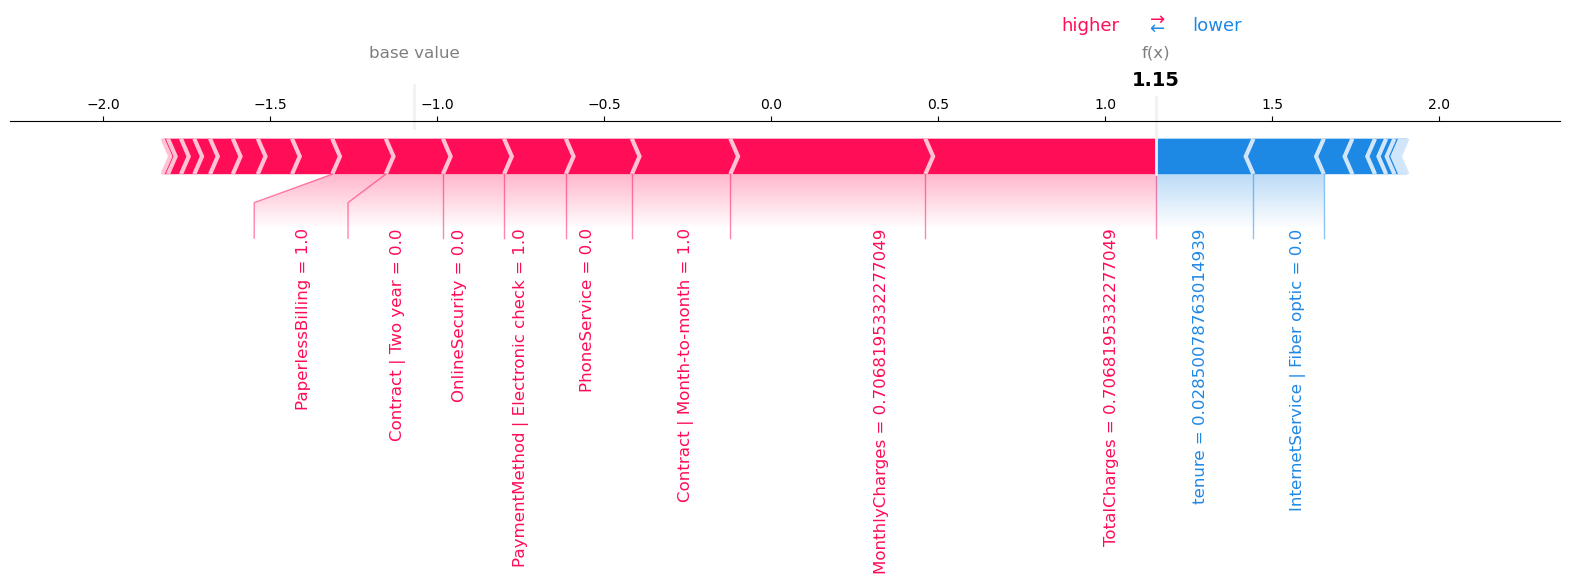

In [15]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:], matplotlib = True, text_rotation = 90);

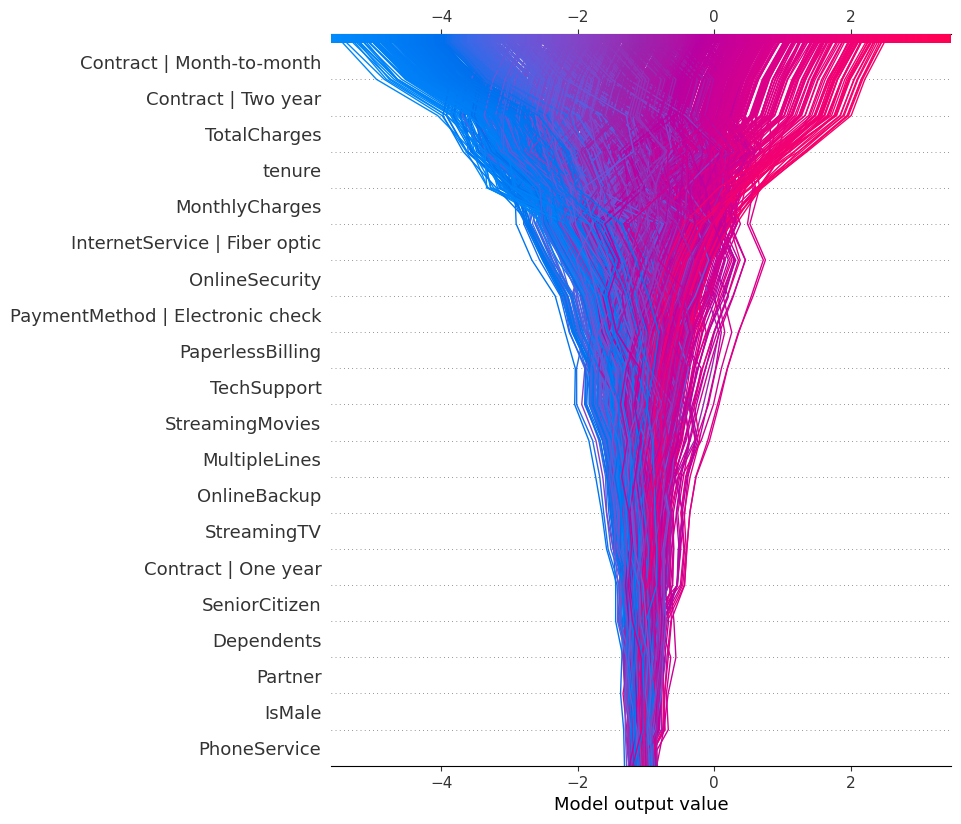

In [16]:
shap.decision_plot(explainer.expected_value, shap_values, X_test.columns)

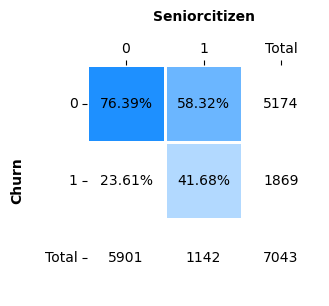

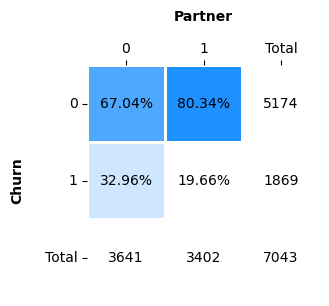

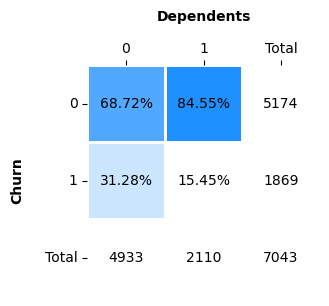

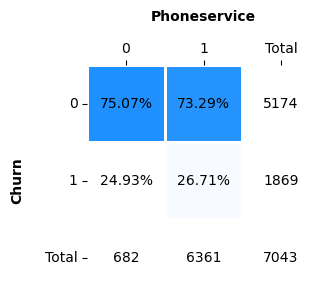

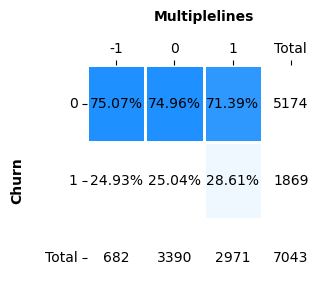

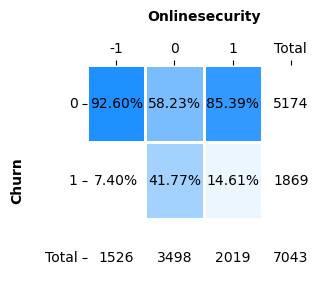

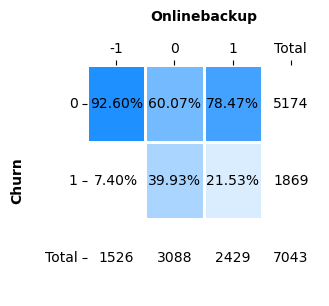

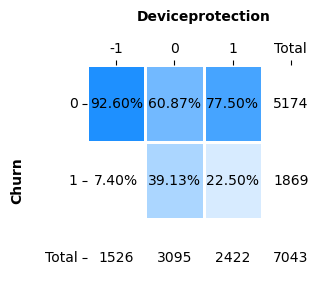

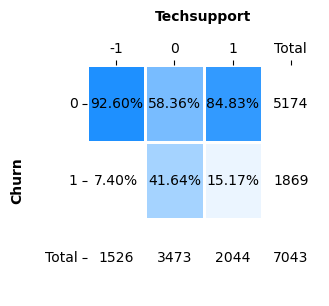

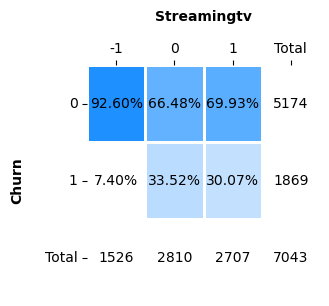

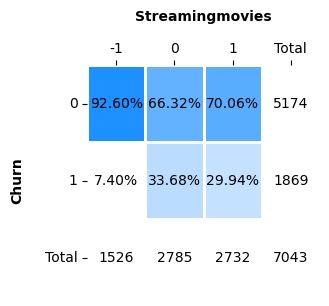

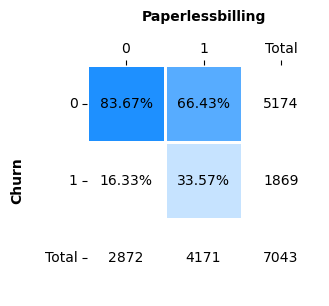

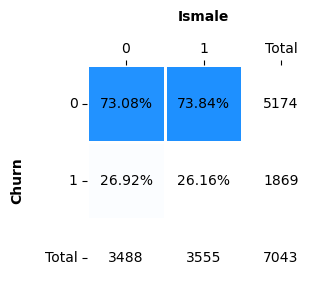

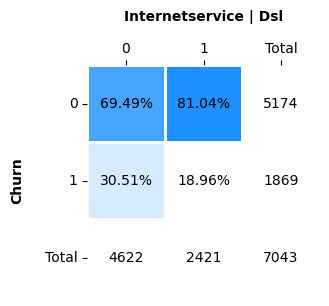

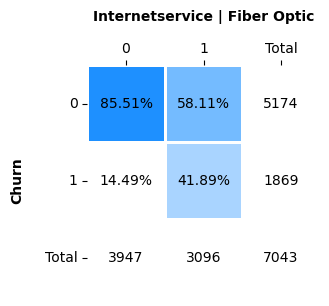

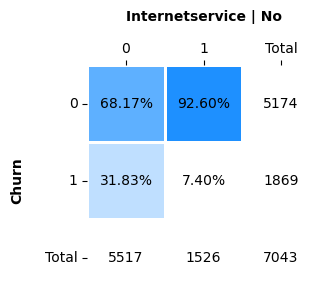

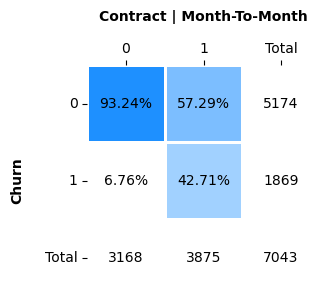

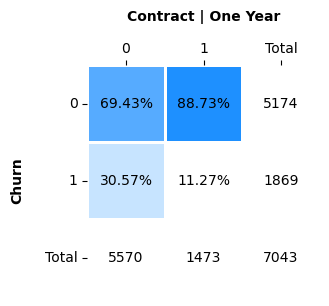

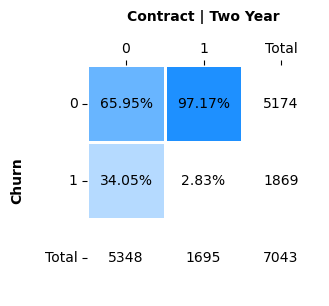

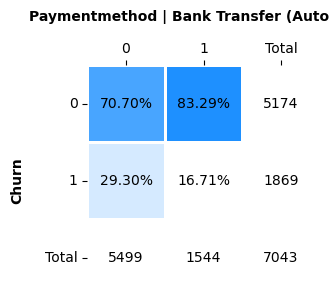

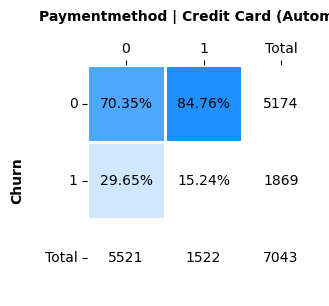

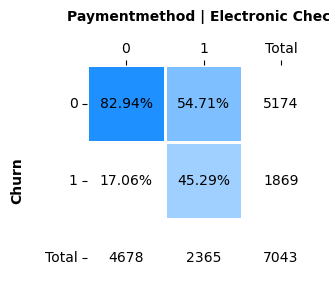

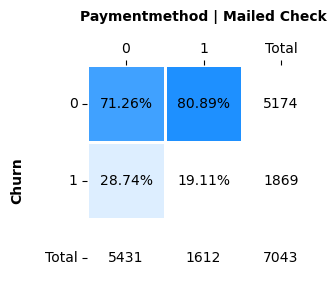

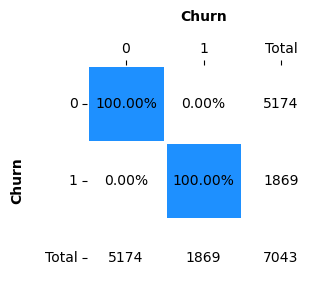

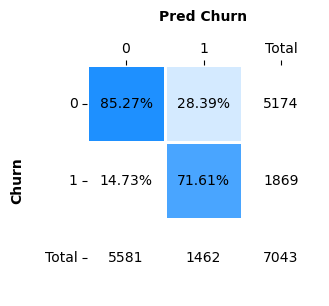

In [17]:
cmap = LinearSegmentedColormap.from_list('color',['white','dodgerblue'])

for col in df.columns:
    if df[col].nunique() <= 5:
        advanced_crosstab(df, row = 'Churn', col = col, normalize_by = 'col', change = 'drop', chart_size = (3,3), cmap = cmap, line = 'white', text = 10, rotation = 0)

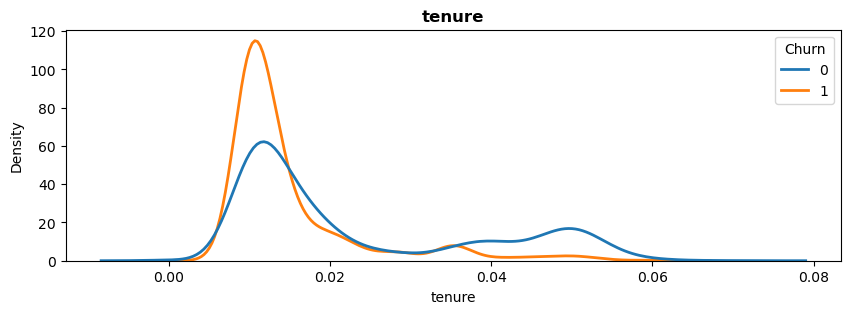

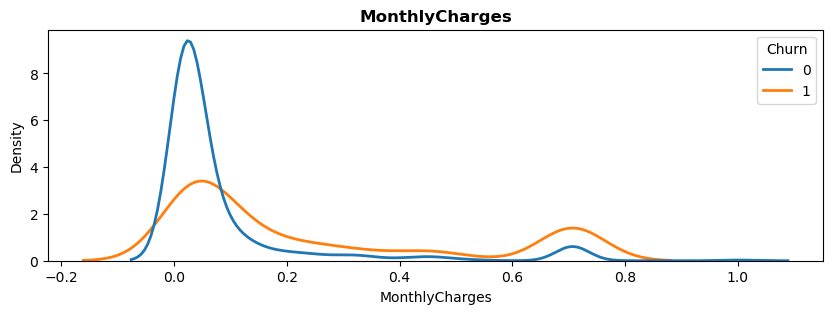

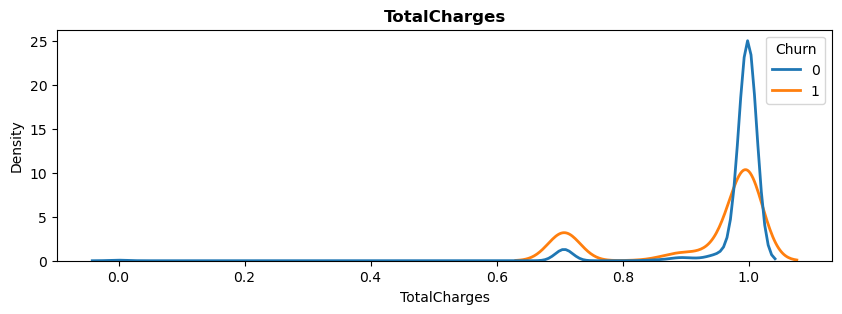

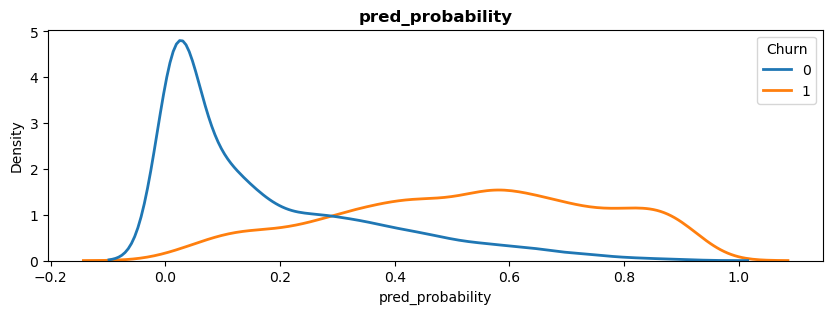

In [18]:
numeric_cols = []

for col in df.columns:
    if df[col].nunique() > 10:
        numeric_cols.append(col)
            
for col in numeric_cols:
    plt.figure(figsize = (10,3))
    sns.kdeplot(data = df, x = col, hue = 'Churn', common_norm = False, lw = 2).set_title(col, weight = 'bold')
    plt.show()

In [19]:
df.head(3).T

,0,1,2
SeniorCitizen,0.000000,0.000000,0.000000
Partner,1.000000,0.000000,0.000000
Dependents,0.000000,0.000000,0.000000
PhoneService,0.000000,1.000000,1.000000
MultipleLines,-1.000000,0.000000,0.000000
OnlineSecurity,0.000000,1.000000,1.000000
OnlineBackup,1.000000,0.000000,1.000000
DeviceProtection,0.000000,1.000000,0.000000
TechSupport,0.000000,0.000000,0.000000
StreamingTV,0.000000,0.000000,0.000000
